<a href="https://colab.research.google.com/github/w12l3-c/Brain-Tumour-Detection/blob/main/Brain_Tumour_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load in Dataset from Kaggle
Here: [dataset](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset?select=metadata_rgb_only.csv)

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wallacel","key":"d4846c13171812a348c366972bd73a6b"}'}

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d preetviradiya/brian-tumor-dataset

 97% 104M/107M [00:01<00:00, 67.7MB/s] 
100% 107M/107M [00:01<00:00, 58.3MB/s]


In [ ]:
! mkdir dataset
! unzip brian-tumor-dataset.zip -d dataset

# Import Libraries

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import PIL
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from google.colab import output

# Preprocessing Images and Dataset

In [ ]:
ROOT = '/content/dataset/Brain Tumor Data Set/Brain Tumor Data Set'
TumourSet = os.path.join(ROOT, 'Brain Tumor')
HealthySet = os.path.join(ROOT, 'Healthy')

In [ ]:
input_shape = (512, 512, 3)

In [ ]:
dataset = keras.utils.image_dataset_from_directory(ROOT, image_size=(512, 512))

Found 4514 files belonging to 2 classes.


['Brain Tumor', 'Healthy']
[0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]: Image Size: (32, 512, 512, 3)


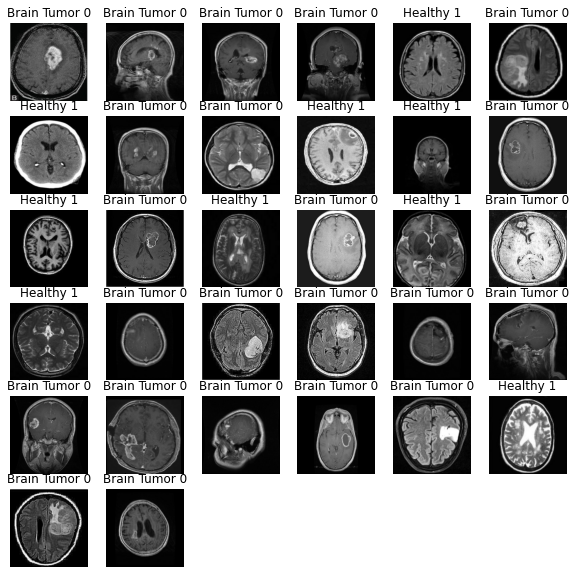

In [ ]:
plt.figure(figsize=(10, 10))
class_names = dataset.class_names
print(class_names)

for images, labels in dataset.take(1):
  print(f"{labels}: Image Size: {images.shape}")
  for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[labels[i]]} {labels[i]}")
        plt.axis("off")

In [ ]:
print(f"The dataset lenght is {dataset.cardinality().numpy()}")

The dataset lenght is 142


In [ ]:
# Separating the train and test dataset
skipping = 10
skip = 5
train = dataset.skip(skipping)
test_val = dataset.take(skipping)
test = test_val.skip(skip)
val = test_val.take(skip)

In [ ]:
print(f'Number of train batch: {train.cardinality().numpy()}')
print(f'Number of test batch: {test.cardinality().numpy()}')
print(f'Number of validation batch: {val.cardinality().numpy()}')

Number of train batch: 132
Number of test batch: 5
Number of validation batch: 5


In [ ]:
for image, label in train.take(5):
  print(f"{label}: Image Size: {image.shape}")

[1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1]: Image Size: (32, 512, 512, 3)
[1 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0]: Image Size: (32, 512, 512, 3)
[1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1]: Image Size: (32, 512, 512, 3)
[1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1]: Image Size: (32, 512, 512, 3)
[1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1]: Image Size: (32, 512, 512, 3)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [ ]:
trainGen = keras.preprocessing.image.ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [ ]:
dataAug = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

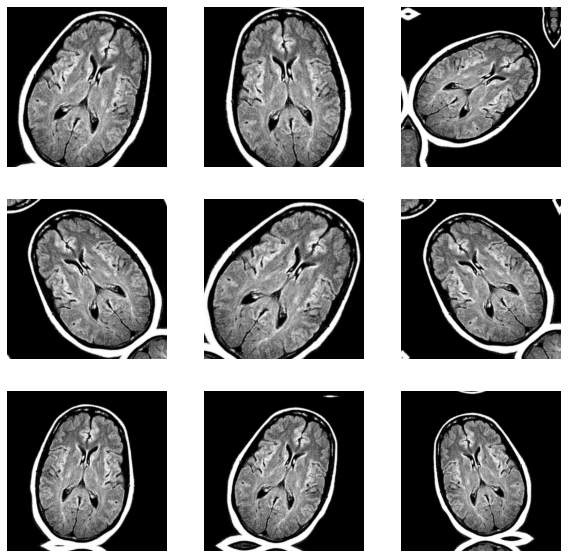

In [ ]:
for image, _ in train.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = dataAug(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Simple CNN model

In [ ]:
class CallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get("accuracy") is not None):
      if (logs.get("accuracy") == 0.99):
        print("Model stop training")
        self.model.stop_training = True

In [ ]:
CNN = None

In [ ]:
CNN = keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
CNN.compile(optimizer='adam', loss=keras.losses.MAE, metrics=['accuracy'])

In [ ]:
CNN.build(input_shape=(1, 512, 512, 3))

In [ ]:
CNN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (1, 512, 512, 3)          0         
                                                                 
 conv2d_24 (Conv2D)          multiple                  448       
                                                                 
 max_pooling2d_24 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          multiple                  4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  multiple               

In [ ]:
historyC = CNN.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
132/132 [==============================] - 48s 242ms/step - loss: 0.5407 - accuracy: 0.4592 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 2/10
132/132 [==============================] - 39s 259ms/step - loss: 0.5403 - accuracy: 0.4597 - val_loss: 0.5000 - val_accuracy: 0.5000
Epoch 3/10
132/132 [==============================] - 37s 259ms/step - loss: 0.5415 - accuracy: 0.4585 - val_loss: 0.5250 - val_accuracy: 0.4750
Epoch 4/10
132/132 [==============================] - 36s 248ms/step - loss: 0.5389 - accuracy: 0.4611 - val_loss: 0.4750 - val_accuracy: 0.5250
Epoch 5/10
132/132 [==============================] - 34s 239ms/step - loss: 0.5401 - accuracy: 0.4599 - val_loss: 0.4688 - val_accuracy: 0.5312
Epoch 6/10
132/132 [==============================] - 35s 239ms/step - loss: 0.5396 - accuracy: 0.4604 - val_loss: 0.4625 - val_accuracy: 0.5375
Epoch 7/10
132/132 [==============================] - 35s 244ms/step - loss: 0.5393 - accuracy: 0.4607 - val_loss: 0.4750 - val_ac

In [ ]:
prediction = CNN.evaluate(test)

5/5 [==============================] - 3s 161ms/step - loss: 0.4750 - accuracy: 0.5250


In [ ]:
CNN.save("BrainT_Diagnose.h5")

In [ ]:
CNN.save_weights('initial_weights')

## Using Pretrained Models

<sub><sup>cuz the model from scratch acc is 52 :(</sup></sub>

Update:
This is way better, acc is 92 :)

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

In [ ]:
baseModel = EfficientNetB0(input_shape = input_shape,
                             include_top = False,
                             weights = "imagenet")

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
baseModel.summary()

In [ ]:
image_batch, label_batch = next(iter(train))
feature_batch = baseModel(image_batch)
print(feature_batch.shape)

(32, 16, 16, 1280)


In [ ]:
# Freeze weights
for layer in baseModel.layers:
  layer.trainable = False

In [ ]:
# add classification head
global_avg = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_avg(feature_batch)
print(feature_batch_avg.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_avg)
print(prediction_batch.shape)

(32, 1)


In [ ]:
input = tf.keras.Input(shape=(512, 512, 3))
x = baseModel(input)
x = global_avg(x)
output = prediction_layer(x)

model = tf.keras.Model(input, output)

In [ ]:
model.compile(optimizer='adam', loss=keras.losses.MAE, metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 16, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
historyP = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
132/132 [==============================] - 56s 352ms/step - loss: 0.3398 - accuracy: 0.8045 - val_loss: 0.2332 - val_accuracy: 0.9000
Epoch 2/5
132/132 [==============================] - 52s 369ms/step - loss: 0.2298 - accuracy: 0.9065 - val_loss: 0.2112 - val_accuracy: 0.9125
Epoch 3/5
132/132 [==============================] - 50s 354ms/step - loss: 0.2123 - accuracy: 0.9247 - val_loss: 0.1966 - val_accuracy: 0.9438
Epoch 4/5
132/132 [==============================] - 48s 338ms/step - loss: 0.1917 - accuracy: 0.9328 - val_loss: 0.1756 - val_accuracy: 0.9625
Epoch 5/5
132/132 [==============================] - 49s 348ms/step - loss: 0.1855 - accuracy: 0.9402 - val_loss: 0.1736 - val_accuracy: 0.9375


In [ ]:
predictions = model.evaluate(test)
loss, acc = predictions
print(f'Loss: {round(loss, 4)}')
print(f'Accuracy: {round(acc, 4)}')

5/5 [==============================] - 4s 302ms/step - loss: 0.1631 - accuracy: 0.9375
Loss: 0.1631
Accuracy: 0.9375


1/1 [==============================] - 2s 2s/step
[1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0]: Image Size: (32, 512, 512, 3)


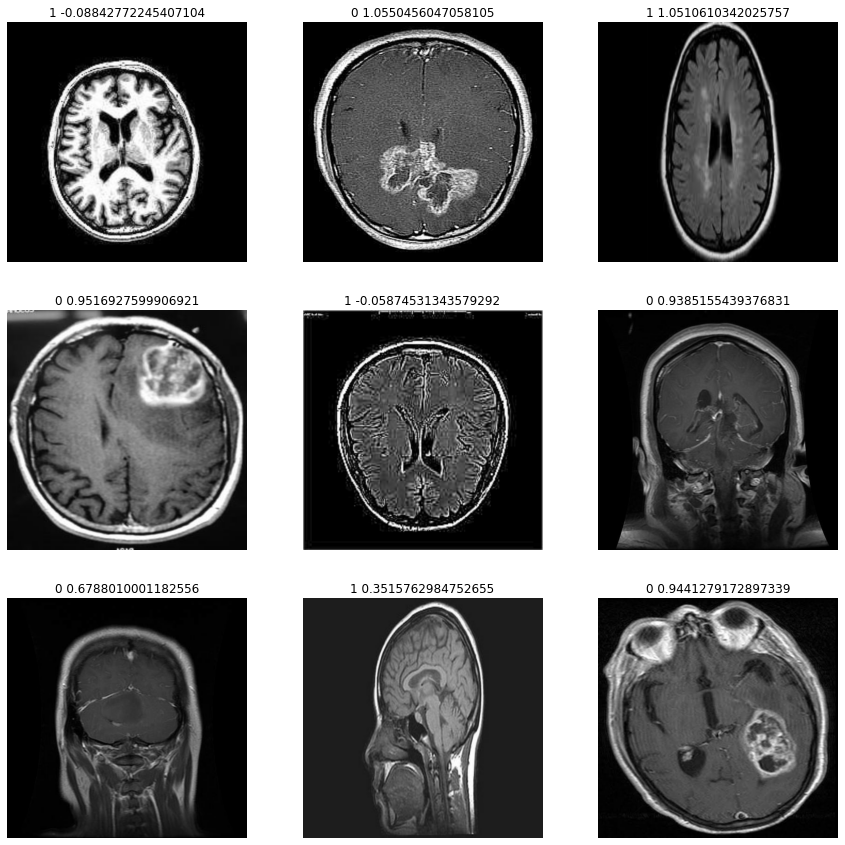

In [122]:
pred_test_data = test.take(1)
pred_test = model.predict(pred_test_data)
class_names = dataset.class_names

for images, labels in pred_test_data:
  plt.figure(figsize=(15, 15))
  print(f"{labels}: Image Size: {images.shape}")
  for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # pred_score = pred_test[i][0]
        # pred_score = tf.clip_by_value(pred_score, 0, 1)
        # pred_score = round(pred_score, 2)
        # txt = '{score:.2f}'
        # txt = txt.format(score=pred_score)
        
        plt.title(f"{labels[i]} {pred_test[i][0]}")
        plt.axis('off')

In [ ]:
model.save("BrainT_Diagnose.h5")

In [ ]:
model.save_weights('initial_weights')

# Dummy Case

Photo from: 
- [Tumour brain](https://pubs.rsna.org/cms/10.1148/radiol.14140130/asset/images/medium/radiol.14140130.fig8a.gif)<br>
- [Healthy brain](https://prod-images-static.radiopaedia.org/images/13656005/bd937738ad6223a03f8aedcf4920a7_big_gallery.jpeg)

In [ ]:
# Import from local
healthy = 'healthy.jpeg'
tumour = 'tumour.jpg'

In [ ]:
healthy = PIL.Image.open(healthy)
tumour = PIL.Image.open(tumour)

In [ ]:
print(f'Healthy size: {healthy.size} \nTumour size: {tumour.size}')

Healthy size: (630, 630) 
Tumour size: (409, 500)


In [ ]:
IMG_SIZE = 512

In [ ]:
healthy = healthy.resize((IMG_SIZE, IMG_SIZE))
tumour = tumour.resize((IMG_SIZE, IMG_SIZE))

In [ ]:
healthy = healthy.convert('RGB')

In [ ]:
healthy = healthy.save('healthy_brain.jpeg')
tumour = tumour.save('tumour_brain.jpg')

In [123]:
pred_data = keras.utils.image_dataset_from_directory('/content/test', image_size=(512, 512))

Found 2 files belonging to 2 classes.


In [124]:
pred = model.predict(pred_data)

1/1 [==============================] - 0s 103ms/step


In [125]:
def diagnose(num):
  if num > 0.5:
    print('Tumour')
  else:
    print('Healthy')

In [126]:
diagnose(pred[0][0])
diagnose(pred[1][0])

Healthy
Tumour
